# TP2 - Géométrie Algorithmique & Morphologie mathématique
By Edouard DUCLOY && Maxime LEDIEU
MS IA - 29/02/2024

Ce notebook détaille une méthode d'optimisation des hyperparamètres pour un algorithme de segmentation d'images, axé spécifiquement sur les images de fond d'œil. L'approche adoptée procède en deux phases distinctes : une optimisation locale suivie d'une optimisation globale, toutes deux orchestrées par la bibliothèque Optuna.

Le processus se déroule comme suit :

1. **Chargement des données :** Le script initie le processus en chargeant les images d'intérêt ainsi que leurs images de référence correspondantes (vérité terrain). Ces paires d'images servent de base pour évaluer l'efficacité de l'algorithme de segmentation.

2. **Fonction objectif pour Optuna :** Une fonction spécialement conçue pour l'optimisation avec Optuna (`objective`) ajuste les paramètres clés de la segmentation (tels que le `clip_limit`, `sigma`, `frequency`, et `seuil`) et mesure la performance de segmentation en calculant le score F1 en comparaison avec la vérité terrain.

3. **Optimisation des paramètres :** L'optimisation est lancée à l'aide de `optuna.create_study()` et `study.optimize()`, où `n_trials` spécifie le nombre de combinaisons d'hyperparamètres à tester par Optuna.

4. **Analyse des résultats :** Une fois l'optimisation terminée, le notebook affiche les paramètres optimaux trouvés ainsi que les scores F1 associés, offrant un aperçu des performances de l'algorithme de segmentation et des pistes potentielles d'amélioration.

5. **Post-traitement :** Des fonctions de post-traitement peuvent être appliquées aux images segmentées pour raffiner les résultats finaux.

6. **Visualisation :** Des fonctions intégrées permettent de visualiser les images avant et après traitement, ainsi que les résultats de segmentation, facilitant l'analyse qualitative des performances.

Pour utiliser efficacement ce notebook, il est recommandé de comprendre l'impact de chaque hyperparamètre sur le processus de segmentation et d'ajuster le nombre d'essais (`n_trials`) pour trouver un équilibre entre la précision de l'optimisation et le temps de calcul requis.

In [1]:
import logging
import time

import numpy as np
from PIL import Image
from scipy.ndimage import rotate
from skimage import exposure, morphology
from skimage.filters import gaussian, gabor
from skimage.measure import label, regionprops
from skimage.morphology import (binary_dilation, black_tophat, closing, disk, erosion, opening, reconstruction,
                                 remove_small_objects, square, thin)
import optuna


def my_segmentation(img, img_mask, seuil):
    # Effectue la segmentation en appliquant un seuil et en le combinant avec un masque.
    img_out = img_mask & (img < seuil)
    return img_out

def evaluate(img_out, img_GT):
    # Évalue le résultat de la segmentation par rapport à la vérité terrain en calculant la précision, le rappel et le score F1.
    GT_skel = thin(img_GT, max_num_iter=15)
    img_out_skel = thin(img_out, max_num_iter=15)
    TP = np.sum(img_out_skel & img_GT)
    FP = np.sum(img_out_skel & ~img_GT)
    FN = np.sum(GT_skel & ~img_out)
    ACCU = TP / (TP + FP) if (TP + FP) > 0 else 0
    RECALL = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (ACCU * RECALL) / (ACCU + RECALL) if (ACCU + RECALL) > 0 else 0
    return ACCU, RECALL, f1_score, img_out_skel, GT_skel

def generate_footprint(length, orientation):
    """
    Crée un élément structurant (footprint) de forme carrée et orienté selon l'angle spécifié.
    
    Args:
        length (int): La taille du côté du carré de l'élément structurant.
        orientation (float): L'angle d'orientation de l'élément structurant en degrés.
        
    Returns:
        np.ndarray: Un tableau numpy binaire représentant l'élément structurant orienté.
    """
    # Génère un élément structurant (footprint) de forme carrée avec une orientation spécifiée.
    square = np.zeros((length, length))
    square[length // 2, :] = 1
    footprint = rotate(square, orientation, order=0, mode='constant', cval=0)
    footprint = footprint > 0
    return footprint


def filter_connected_components(seg_img, min_size=3):
    """
    Élimine les petites composantes connectées d'une image segmentée en fonction d'un seuil de taille minimal.
    
    Args:
        seg_img (np.ndarray): L'image segmentée dont les composantes connectées seront filtrées.
        min_size (int): La taille minimale requise pour les composantes connectées à conserver.
        
    Returns:
        np.ndarray: L'image segmentée après l'élimination des petites composantes connectées.
    """
    # Filtre les composantes connectées dans l'image segmentée en éliminant celles de taille inférieure à un seuil.
    # Étiqueter les composantes connectées
    labeled_img = label(seg_img)
    # Filtrer les petites composantes connectées
    filtered_img = remove_small_objects(labeled_img, min_size=min_size)
    # Convertir en image binaire
    filtered_binary_img = filtered_img > 0
    return filtered_binary_img

def optimized_dilation_post_process(seg_img, kernel_size=1):
    """
    Applique une dilatation binaire à l'image segmentée en utilisant un noyau de dilatation de taille spécifiée.
    
    Args:
        seg_img (np.ndarray): L'image segmentée à traiter par dilatation.
        kernel_size (int): Le diamètre du disque utilisé comme élément structurant pour la dilatation.
        
    Returns:
        np.ndarray: L'image segmentée après l'application de la dilatation binaire.
    """
    # Applique une dilatation binaire optimisée à l'image segmentée en utilisant un noyau de taille spécifiée.
    kernel = disk(kernel_size)
    return binary_dilation(seg_img, kernel)

# Callback pour suivre la progression et afficher le meilleur score F1 avec les paramètres
def print_progress_and_best_f1_with_params(study, trial):
    # Affiche la progression et le meilleur score F1 avec les paramètres lors de l'optimisation avec Optuna.
    completed_trials = len(study.trials)
    total_trials = optuna_n_trial
    progress_percent = 100.0 * completed_trials / total_trials

    # Obtenir le meilleur score F1 et les paramètres associés jusqu'à présent
    best_f1_score = -study.best_value if study.best_value is not None else None
    best_params = {k: round(v, 3) for k, v in study.best_trial.params.items()} if study.best_trial is not None else None

    # Imprimer la progression avec le meilleur score F1 et les paramètres à chaque 10%
    if completed_trials % (total_trials // 10) == 0 or completed_trials == total_trials:
        params_text = ', '.join(f"{k}: {v}" for k, v in best_params.items()) if best_params is not None else 'N/A'
        print(f"Progress: {int(progress_percent)}% - Best F1 Score: {best_f1_score:.3f} - Params: {params_text}")


# Optimisation Locale sur l'image 32_ODC

In [12]:
#Image 32_ODC
# Ce script charge une image et sa vérité terrain, puis utilise une optimisation basée sur Optuna
# pour trouver les meilleurs paramètres de segmentation. La segmentation implique plusieurs étapes de traitement d'image,
# y compris l'égalisation adaptative du contraste, l'application de filtres de Gabor, et différentes opérations morphologiques.
# Le résultat est évalué en fonction du score F1 par rapport à la vérité terrain.

img = np.asarray(Image.open('/kaggle/input/image-slo-and-gt/star32_ODC.jpg')).astype(np.uint8)  # Chargement de l'image
img_GT = np.asarray(Image.open('/kaggle/input/image-slo-and-gt/GT_32.png')).astype(np.bool_)  # Chargement de la vérité terrain
optuna_n_trial=1000  # Nombre d'essais pour l'optimisation


def objective(trial):
    """
    Fonction objectif pour l'optimisation avec Optuna, conçue pour ajuster et trouver les meilleurs paramètres
    de traitement d'image afin de maximiser le score F1 pour la tâche de segmentation d'image.

    Cette fonction utilise Optuna pour suggérer des valeurs pour plusieurs hyperparamètres, y compris le 'clip_limit'
    pour l'égalisation adaptative du contraste, 'sigma' pour le lissage gaussien, 'frequency' pour le filtrage de Gabor,
    et 'seuil' pour la segmentation binaire. Ces paramètres sont ensuite utilisés dans une chaîne de traitement d'image
    pour produire une image segmentée, qui est évaluée par rapport à une vérité terrain pour calculer le score F1.

    Args:
        trial (optuna.trial.Trial): Un essai Optuna qui permet de suggérer des valeurs pour les hyperparamètres.

    Returns:
        Le score F1 négatif de la segmentation, utilisé comme valeur à minimiser par le processus d'optimisation.
    """
    # Définit l'objectif pour l'optimisation Optuna, cherchant à maximiser le score F1 de la segmentation
    clip_limit = trial.suggest_float('clip_limit', 0.007, 0.014)  # Limite pour l'égalisation adaptative du contraste
    sigma = trial.suggest_float('sigma', 0.5, 1.8)  # Sigma pour le filtre gaussien
    frequency = trial.suggest_float('frequency', 0.5, 1.7)  # Fréquence pour le filtre de Gabor
    seuil = trial.suggest_int('seuil', 150, 240)  # Seuil pour la segmentation
    
    # Égalisation adaptative du contraste, convertissant le résultat en format 8 bits
    contrast_img = (255 * exposure.equalize_adapthist(img, clip_limit=clip_limit)).astype(np.uint8)

    # Applique le filtre de Gabor
    gabor_real, gabor_imag = gabor(contrast_img, frequency=frequency)
    gabor_img = np.abs(gabor_real)  # Use the absolute value of the real part

    # Opérations morphologiques pour améliorer la segmentation

    # Application d'une ouverture morphologique avec différentes orientations pour améliorer les contours de l'image
    open_imgs = []
    for orientation in range(0, 180, 10):
        open_imgs.append(opening(gabor_img, footprint=generate_footprint(15, orientation)))
    open_img = np.maximum.reduce(open_imgs)  # Fusion des images ouvertes pour obtenir le meilleur résultat

    # Application d'un chapeau haut-de-forme noir pour extraire de petits éléments et détails de l'image
    bth_img = np.zeros(img.shape)
    for orientation in range(0, 180, 10):
        bth_img += black_tophat(open_img, footprint=generate_footprint(7, orientation))

    # Utilisation de l'érosion morphologique pour affiner les structures et supprimer le bruit
    erosion_imgs = []
    for orientation in range(0, 180, 10):
        erosion_imgs.append(erosion(bth_img, footprint=generate_footprint(15, orientation)))
    erosion_img = np.minimum(np.maximum.reduce(erosion_imgs), bth_img)  # Combinaison des résultats d'érosion

    # Reconstruction morphologique pour restaurer les structures originales de l'image tout en conservant les améliorations
    reconstruction_img = reconstruction(erosion_img, bth_img, method='dilation')

    # Application d'un filtre gaussien pour lisser l'image et réduire le bruit
    filt_img = gaussian(reconstruction_img, sigma=sigma)

    # Segmentation de l'image en utilisant un seuil et l'image filtrée
    seg_img = my_segmentation(255-filt_img, img_mask, seuil)

    # Post-traitement Filtrage des composantes connectées pour éliminer les petits objets et le bruit résiduel
    seg_img_filtered = filter_connected_components(seg_img)

    # Post-traitement par dilatation pour fermer les petits trous et améliorer la continuité des structures segmentées
    seg_img_post_dilation = optimized_dilation_post_process(seg_img_filtered, kernel_size=1)

    ACCU, RECALL, _, _,_ = evaluate(seg_img_post_dilation, img_GT)
    f1_score = 2 * (ACCU * RECALL) / (ACCU + RECALL) if (ACCU + RECALL) > 0 else 0
    
    return -f1_score  # Minimise le négatif du score F1 pour l'optimisation

# Désactivation des logs d'Optuna pour un affichage épuré
optuna.logging.set_verbosity(optuna.logging.WARNING)

if __name__ == "__main__":
    # Démarre le chronomètre pour calculer le temps d'exécution total du script
    start_time = time.time()

    nrows, ncols = img.shape
    row, col = np.ogrid[:nrows, :ncols]
    img_mask = np.ones(img.shape).astype(np.bool_)
    invalid_pixels = ((row - nrows / 2) ** 2 + (col - ncols / 2) ** 2 > (nrows / 2) ** 2)
    img_mask[invalid_pixels] = 0
    
    # Création d'une étude Optuna pour minimiser la fonction objectif, qui est basée sur le score F1 négatif
    study = optuna.create_study(direction='minimize')
    # Lancement de l'optimisation avec un nombre défini d'essais et une fonction de rappel pour afficher la progression
    study.optimize(objective, n_trials=optuna_n_trial, callbacks=[print_progress_and_best_f1_with_params], n_jobs=-1)

    # Arrêt du chronomètre après la fin de l'optimisation et calcul du temps total passé
    end_time = time.time()
    total_time = end_time - start_time
    # Affichage du temps de calcul total nécessaire pour exécuter l'optimisation
    print(f"\nTotal computation time: {total_time:.2f} seconds")

    # Récupération et affichage des meilleurs paramètres trouvés par l'optimisation Optuna
    best_params = {k: round(v, 3) for k, v in study.best_params.items()}
    print("Best Params:", best_params)


# Ré-exécution de la segmentation avec les meilleurs paramètres trouvés
# Amélioration du contraste de l'image originale en utilisant l'égalisation adaptative du contraste avec le meilleur paramètre 'clip_limit'
contrast_img = (255 * exposure.equalize_adapthist(img, clip_limit=best_params['clip_limit'])).astype(np.uint8)

# Application du filtre de Gabor avec le meilleur paramètre de fréquence pour extraire les caractéristiques de texture
gabor_real, gabor_imag = gabor(contrast_img, frequency=best_params['frequency'])
gabor_img = np.abs(gabor_real)  # Utilisation de la valeur absolue de la partie réelle pour obtenir l'intensité des caractéristiques

# Application de l'opération d'ouverture morphologique avec différentes orientations pour améliorer les contours et les structures
open_imgs = []
for orientation in range(0, 180, 10):
    open_imgs.append(opening(gabor_img, footprint=generate_footprint(15, orientation)))
open_img = np.maximum.reduce(open_imgs)  # Fusion des images résultantes pour garder les meilleurs contours

# Utilisation du chapeau haut-de-forme noir pour mettre en évidence les petits objets et les détails fins dans l'image
bth_img = np.zeros(img.shape)
for orientation in range(0, 180, 10):
    bth_img += black_tophat(open_img, footprint=generate_footprint(7, orientation))

# Application de l'érosion morphologique pour affiner les structures et réduire le bruit, avec différentes orientations
erosion_imgs = []
for orientation in range(0, 180, 10):
    erosion_imgs.append(erosion(bth_img, footprint=generate_footprint(15, orientation)))
erosion_img = np.minimum(np.maximum.reduce(erosion_imgs), bth_img)  # Combinaison des images pour obtenir le meilleur résultat d'érosion

# Reconstruction morphologique pour restaurer les structures originales tout en conservant les améliorations apportées par l'érosion et le chapeau haut-de-forme noir
reconstruction_img = reconstruction(erosion_img, bth_img, method='dilation')

# Application d'un filtre gaussien pour lisser l'image résultante, en utilisant le meilleur paramètre 'sigma'
filt_img = gaussian(reconstruction_img, sigma=best_params['sigma'])

# Segmentation finale de l'image en appliquant un seuil, en utilisant le meilleur paramètre 'seuil'
seg_img = my_segmentation(255 - filt_img, img_mask, best_params['seuil'])

# Filtrage des petites composantes connectées pour éliminer le bruit et améliorer la qualité de la segmentation
seg_img_filtered = filter_connected_components(seg_img)

# Post-traitement par dilatation pour fermer les petits trous et améliorer la continuité des structures segmentées, avec un noyau de taille optimisée
seg_img_post_dilation = optimized_dilation_post_process(seg_img_filtered, kernel_size=1)

# Évaluation sans post-traitement
ACCU, RECALL, F1, _, GT_skel = evaluate(seg_img, img_GT)
print("Performance sans post-traitement :")
print("F1 Score:", F1)
print("Accuracy:", ACCU)
print("Recall:", RECALL)

# Évaluation avec post-traitement
ACCU, RECALL, F1, _, GT_skel = evaluate(seg_img_post_dilation, img_GT)
print("Performance avec post-traitement :")
print("F1 Score:", F1)
print("Accuracy:", ACCU)
print("Recall:", RECALL)


Progress: 10% - Best F1 Score: 0.854 - Params: clip_limit: 0.013, sigma: 0.91, frequency: 0.849, seuil: 172
Progress: 20% - Best F1 Score: 0.856 - Params: clip_limit: 0.012, sigma: 0.907, frequency: 0.817, seuil: 185
Progress: 30% - Best F1 Score: 0.858 - Params: clip_limit: 0.012, sigma: 0.81, frequency: 0.777, seuil: 191
Progress: 40% - Best F1 Score: 0.858 - Params: clip_limit: 0.012, sigma: 0.81, frequency: 0.777, seuil: 191
Progress: 50% - Best F1 Score: 0.858 - Params: clip_limit: 0.012, sigma: 0.82, frequency: 0.791, seuil: 187
Progress: 60% - Best F1 Score: 0.858 - Params: clip_limit: 0.012, sigma: 0.82, frequency: 0.791, seuil: 187Progress: 60% - Best F1 Score: 0.858 - Params: clip_limit: 0.012, sigma: 0.82, frequency: 0.791, seuil: 187

Progress: 70% - Best F1 Score: 0.859 - Params: clip_limit: 0.013, sigma: 0.832, frequency: 0.78, seuil: 187
Progress: 80% - Best F1 Score: 0.859 - Params: clip_limit: 0.013, sigma: 0.832, frequency: 0.78, seuil: 187
Progress: 90% - Best F1 Sco

# Optimisation Locale sur l'image 21_OSC

In [13]:
#Image 21_OSC
# Ce script charge une image et sa vérité terrain, puis utilise une optimisation basée sur Optuna
# pour trouver les meilleurs paramètres de segmentation. La segmentation implique plusieurs étapes de traitement d'image,
# y compris l'égalisation adaptative du contraste, l'application de filtres de Gabor, et différentes opérations morphologiques.
# Le résultat est évalué en fonction du score F1 par rapport à la vérité terrain.

img = np.asarray(Image.open('/kaggle/input/image-slo-and-gt/star21_OSC.jpg')).astype(np.uint8)
img_GT = np.asarray(Image.open('/kaggle/input/image-slo-and-gt/GT_21.png')).astype(np.bool_)
optuna_n_trial=500  # Nombre d'essais pour l'optimisation

def objective(trial):
    """
    Fonction objectif pour l'optimisation avec Optuna, conçue pour ajuster et trouver les meilleurs paramètres
    de traitement d'image afin de maximiser le score F1 pour la tâche de segmentation d'image.

    Cette fonction utilise Optuna pour suggérer des valeurs pour plusieurs hyperparamètres, y compris le 'clip_limit'
    pour l'égalisation adaptative du contraste, 'sigma' pour le lissage gaussien, 'frequency' pour le filtrage de Gabor,
    et 'seuil' pour la segmentation binaire. Ces paramètres sont ensuite utilisés dans une chaîne de traitement d'image
    pour produire une image segmentée, qui est évaluée par rapport à une vérité terrain pour calculer le score F1.

    Args:
        trial (optuna.trial.Trial): Un essai Optuna qui permet de suggérer des valeurs pour les hyperparamètres.

    Returns:
        Le score F1 négatif de la segmentation, utilisé comme valeur à minimiser par le processus d'optimisation.
    """
    # Définit l'objectif pour l'optimisation Optuna, cherchant à maximiser le score F1 de la segmentation
    clip_limit = trial.suggest_float('clip_limit', 0.009, 0.011)  # Limite pour l'égalisation adaptative du contraste
    sigma = trial.suggest_float('sigma', 1.1, 1.4)  # Sigma pour le filtre gaussien
    frequency = trial.suggest_float('frequency', 0.6, 0.8)  # Fréquence pour le filtre de Gabor
    seuil = trial.suggest_int('seuil', 200, 220)  # Seuil pour la segmentation
    
    # Égalisation adaptative du contraste, convertissant le résultat en format 8 bits
    contrast_img = (255 * exposure.equalize_adapthist(img, clip_limit=clip_limit)).astype(np.uint8)

    # Applique le filtre de Gabor
    gabor_real, gabor_imag = gabor(contrast_img, frequency=frequency)
    gabor_img = np.abs(gabor_real)  # Use the absolute value of the real part

    # Opérations morphologiques pour améliorer la segmentation

    # Application d'une ouverture morphologique avec différentes orientations pour améliorer les contours de l'image
    open_imgs = []
    for orientation in range(0, 180, 10):
        open_imgs.append(opening(gabor_img, footprint=generate_footprint(15, orientation)))
    open_img = np.maximum.reduce(open_imgs)  # Fusion des images ouvertes pour obtenir le meilleur résultat

    # Application d'un chapeau haut-de-forme noir pour extraire de petits éléments et détails de l'image
    bth_img = np.zeros(img.shape)
    for orientation in range(0, 180, 10):
        bth_img += black_tophat(open_img, footprint=generate_footprint(7, orientation))

    # Utilisation de l'érosion morphologique pour affiner les structures et supprimer le bruit
    erosion_imgs = []
    for orientation in range(0, 180, 10):
        erosion_imgs.append(erosion(bth_img, footprint=generate_footprint(15, orientation)))
    erosion_img = np.minimum(np.maximum.reduce(erosion_imgs), bth_img)  # Combinaison des résultats d'érosion

    # Reconstruction morphologique pour restaurer les structures originales de l'image tout en conservant les améliorations
    reconstruction_img = reconstruction(erosion_img, bth_img, method='dilation')

    # Application d'un filtre gaussien pour lisser l'image et réduire le bruit
    filt_img = gaussian(reconstruction_img, sigma=sigma)

    # Segmentation de l'image en utilisant un seuil et l'image filtrée
    seg_img = my_segmentation(255-filt_img, img_mask, seuil)

    # Post-traitement Filtrage des composantes connectées pour éliminer les petits objets et le bruit résiduel
    seg_img_filtered = filter_connected_components(seg_img)

    # Post-traitement par dilatation pour fermer les petits trous et améliorer la continuité des structures segmentées
    seg_img_post_dilation = optimized_dilation_post_process(seg_img_filtered, kernel_size=1)

    ACCU, RECALL, _, _,_ = evaluate(seg_img_post_dilation, img_GT)
    f1_score = 2 * (ACCU * RECALL) / (ACCU + RECALL) if (ACCU + RECALL) > 0 else 0
    
    return -f1_score  # Minimise le négatif du score F1 pour l'optimisation

# Désactivation des logs d'Optuna pour un affichage épuré
optuna.logging.set_verbosity(optuna.logging.WARNING)

if __name__ == "__main__":
    # Démarre le chronomètre pour calculer le temps d'exécution total du script
    start_time = time.time()

    nrows, ncols = img.shape
    row, col = np.ogrid[:nrows, :ncols]
    img_mask = np.ones(img.shape).astype(np.bool_)
    invalid_pixels = ((row - nrows / 2) ** 2 + (col - ncols / 2) ** 2 > (nrows / 2) ** 2)
    img_mask[invalid_pixels] = 0
    
    # Création d'une étude Optuna pour minimiser la fonction objectif, qui est basée sur le score F1 négatif
    study = optuna.create_study(direction='minimize')
    # Lancement de l'optimisation avec un nombre défini d'essais et une fonction de rappel pour afficher la progression
    study.optimize(objective, n_trials=optuna_n_trial, callbacks=[print_progress_and_best_f1_with_params], n_jobs=-1)

    # Arrêt du chronomètre après la fin de l'optimisation et calcul du temps total passé
    end_time = time.time()
    total_time = end_time - start_time
    # Affichage du temps de calcul total nécessaire pour exécuter l'optimisation
    print(f"\nTotal computation time: {total_time:.2f} seconds")

    # Récupération et affichage des meilleurs paramètres trouvés par l'optimisation Optuna
    best_params = {k: round(v, 3) for k, v in study.best_params.items()}
    print("Best Params:", best_params)


# Ré-exécution de la segmentation avec les meilleurs paramètres trouvés
# Amélioration du contraste de l'image originale en utilisant l'égalisation adaptative du contraste avec le meilleur paramètre 'clip_limit'
contrast_img = (255 * exposure.equalize_adapthist(img, clip_limit=best_params['clip_limit'])).astype(np.uint8)

# Application du filtre de Gabor avec le meilleur paramètre de fréquence pour extraire les caractéristiques de texture
gabor_real, gabor_imag = gabor(contrast_img, frequency=best_params['frequency'])
gabor_img = np.abs(gabor_real)  # Utilisation de la valeur absolue de la partie réelle pour obtenir l'intensité des caractéristiques

# Application de l'opération d'ouverture morphologique avec différentes orientations pour améliorer les contours et les structures
open_imgs = []
for orientation in range(0, 180, 10):
    open_imgs.append(opening(gabor_img, footprint=generate_footprint(15, orientation)))
open_img = np.maximum.reduce(open_imgs)  # Fusion des images résultantes pour garder les meilleurs contours

# Utilisation du chapeau haut-de-forme noir pour mettre en évidence les petits objets et les détails fins dans l'image
bth_img = np.zeros(img.shape)
for orientation in range(0, 180, 10):
    bth_img += black_tophat(open_img, footprint=generate_footprint(7, orientation))

# Application de l'érosion morphologique pour affiner les structures et réduire le bruit, avec différentes orientations
erosion_imgs = []
for orientation in range(0, 180, 10):
    erosion_imgs.append(erosion(bth_img, footprint=generate_footprint(15, orientation)))
erosion_img = np.minimum(np.maximum.reduce(erosion_imgs), bth_img)  # Combinaison des images pour obtenir le meilleur résultat d'érosion

# Reconstruction morphologique pour restaurer les structures originales tout en conservant les améliorations apportées par l'érosion et le chapeau haut-de-forme noir
reconstruction_img = reconstruction(erosion_img, bth_img, method='dilation')

# Application d'un filtre gaussien pour lisser l'image résultante, en utilisant le meilleur paramètre 'sigma'
filt_img = gaussian(reconstruction_img, sigma=best_params['sigma'])

# Segmentation finale de l'image en appliquant un seuil, en utilisant le meilleur paramètre 'seuil'
seg_img = my_segmentation(255 - filt_img, img_mask, best_params['seuil'])

# Filtrage des petites composantes connectées pour éliminer le bruit et améliorer la qualité de la segmentation
seg_img_filtered = filter_connected_components(seg_img)

# Post-traitement par dilatation pour fermer les petits trous et améliorer la continuité des structures segmentées, avec un noyau de taille optimisée
seg_img_post_dilation = optimized_dilation_post_process(seg_img_filtered, kernel_size=1)

# Évaluation sans post-traitement
ACCU, RECALL, F1, _, GT_skel = evaluate(seg_img, img_GT)
print("Performance sans post-traitement :")
print("F1 Score:", F1)
print("Accuracy:", ACCU)
print("Recall:", RECALL)

# Évaluation avec post-traitement
ACCU, RECALL, F1, _, GT_skel = evaluate(seg_img_post_dilation, img_GT)
print("Performance avec post-traitement :")
print("F1 Score:", F1)
print("Accuracy:", ACCU)
print("Recall:", RECALL)


Progress: 10% - Best F1 Score: 0.780 - Params: clip_limit: 0.01, sigma: 1.194, frequency: 0.767, seuil: 215
Progress: 20% - Best F1 Score: 0.780 - Params: clip_limit: 0.01, sigma: 1.194, frequency: 0.767, seuil: 215
Progress: 30% - Best F1 Score: 0.782 - Params: clip_limit: 0.01, sigma: 1.205, frequency: 0.781, seuil: 214
Progress: 40% - Best F1 Score: 0.782 - Params: clip_limit: 0.01, sigma: 1.205, frequency: 0.781, seuil: 214
Progress: 50% - Best F1 Score: 0.782 - Params: clip_limit: 0.01, sigma: 1.205, frequency: 0.781, seuil: 214
Progress: 60% - Best F1 Score: 0.782 - Params: clip_limit: 0.01, sigma: 1.127, frequency: 0.778, seuil: 216
Progress: 70% - Best F1 Score: 0.782 - Params: clip_limit: 0.01, sigma: 1.127, frequency: 0.778, seuil: 216
Progress: 80% - Best F1 Score: 0.783 - Params: clip_limit: 0.01, sigma: 1.144, frequency: 0.772, seuil: 216
Progress: 90% - Best F1 Score: 0.783 - Params: clip_limit: 0.01, sigma: 1.144, frequency: 0.772, seuil: 216
Progress: 100% - Best F1 Sco

# Visualisation des résulats locaux

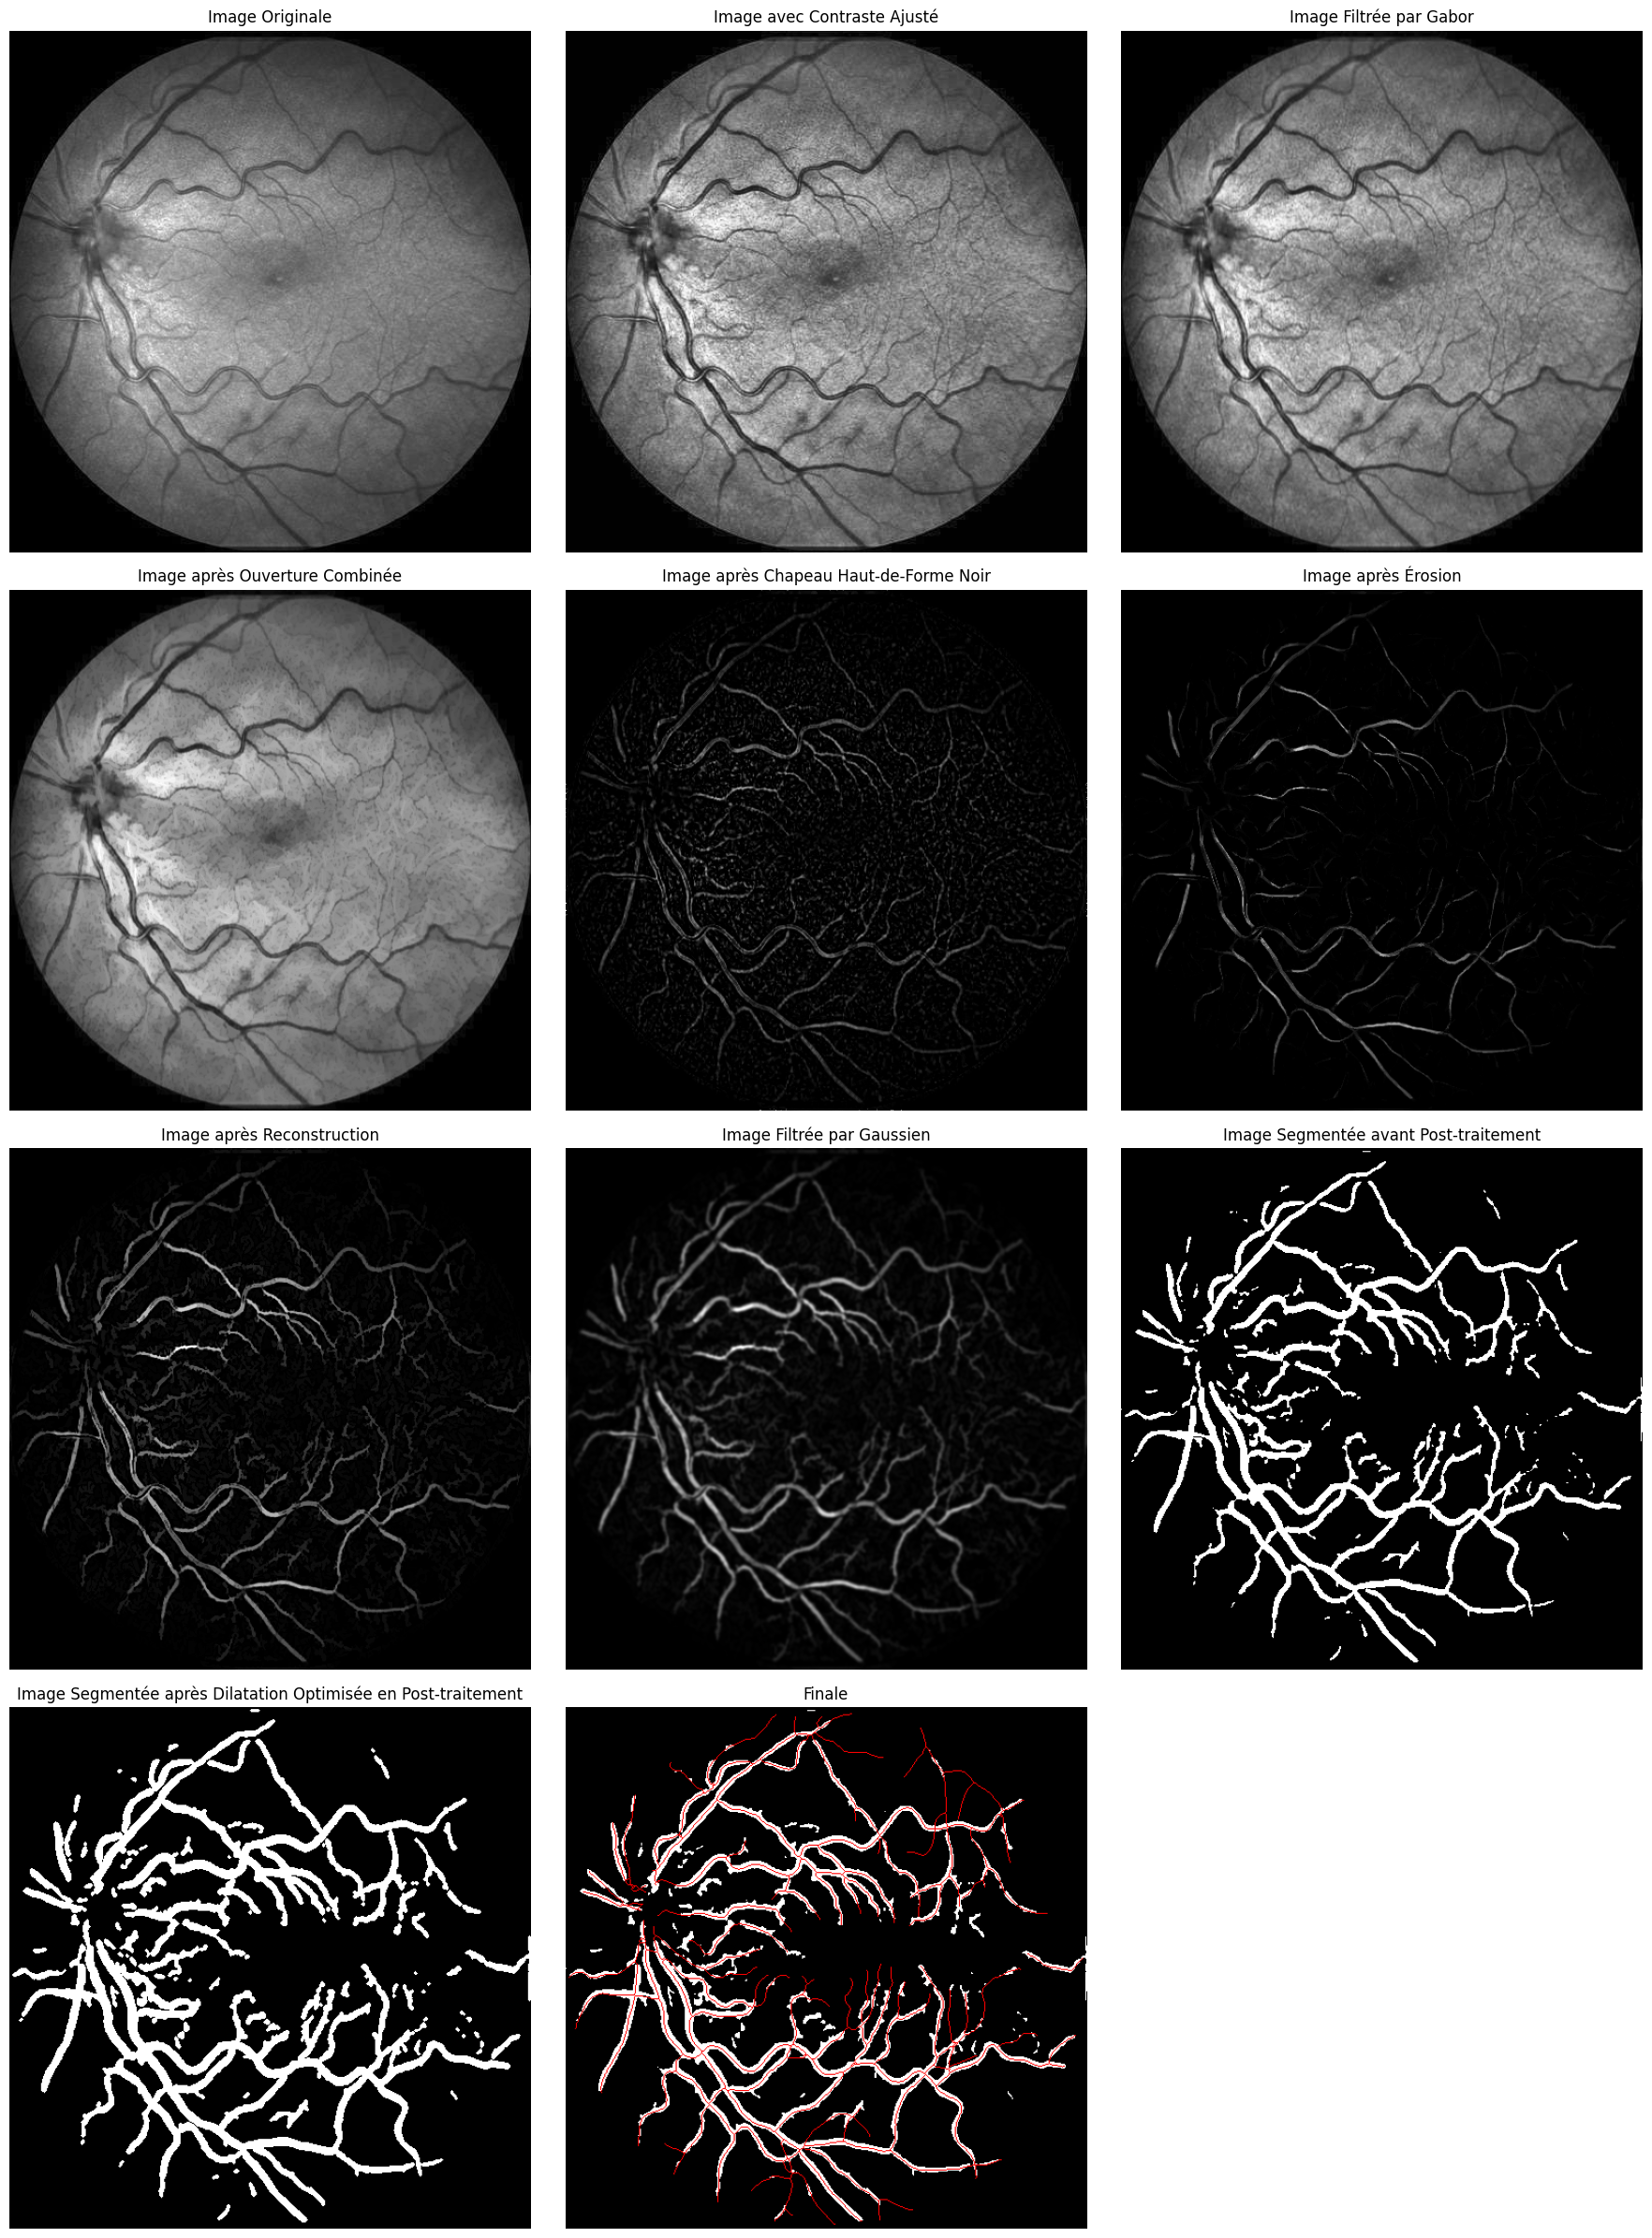

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_image(image, title, index, nrows, ncols, cmap='gray'):
    """Affiche une image dans une grille de sous-graphiques.

    Args:
        image: L'image à afficher.
        title: Titre à afficher au-dessus de l'image.
        index: Position de l'image dans la grille de sous-graphiques.
        nrows: Nombre total de lignes dans la grille de sous-graphiques.
        ncols: Nombre total de colonnes dans la grille de sous-graphiques.
        cmap: Carte de couleurs utilisée pour afficher l'image (par défaut 'gray').
    """
    plt.subplot(nrows, ncols, index)
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')

def superposition(GT, IMG):
    """Superpose un masque (GT) sur une image (IMG) en marquant les régions du masque en rouge.

    Args:
        GT: Image de masque binaire (Ground Truth).
        IMG: Image de fond sur laquelle le masque sera superposé.

    Returns:
        Une image résultante avec le masque superposé en rouge.
    """
    # Convertir l'image de fond en niveaux de gris en une image RGB (3 canaux)
    image_fond_rgb = np.stack([IMG] * 3, axis=-1)

    # Créer une image rouge là où le masque GT est vrai
    image_rouge = np.zeros_like(image_fond_rgb, dtype=np.uint8)
    image_rouge[..., 0] = 255  # canal rouge au maximum

    # Appliquer le masque rouge à l'image de fond
    image_resultat = np.where(GT[:,:,None], image_rouge, image_fond_rgb)
    
    return image_resultat

# Configuration de la grille de sous-graphiques
nrows = 4  # Nombre de lignes de la grille de sous-graphiques
ncols = 3  # Nombre de colonnes de la grille de sous-graphiques
plt.figure(figsize=(ncols * 6, nrows * 6))  # Ajuster la taille selon le besoin

# Affichage de chaque image avec la fonction `plot_image`
plot_image(img, 'Image Originale', 1, nrows, ncols)
plot_image(contrast_img, 'Image avec Contraste Ajusté', 2, nrows, ncols)
plot_image(gabor_img, 'Image Filtrée par Gabor', 3, nrows, ncols)

# Pour les images combinées après ouverture, on appelle directement la fonction ici
index = 4  # Ajuster l'indice de départ selon le besoin
combined_img = np.maximum.reduce(open_imgs)
plot_image(combined_img, 'Image après Ouverture Combinée', index, nrows, ncols)

plot_image(bth_img, 'Image après Chapeau Haut-de-Forme Noir', 5, nrows, ncols)
plot_image(erosion_img, 'Image après Érosion', 6, nrows, ncols)
plot_image(reconstruction_img, 'Image après Reconstruction', 7, nrows, ncols)
plot_image(filt_img, 'Image Filtrée par Gaussien', 8, nrows, ncols)
plot_image(seg_img, 'Image Segmentée avant Post-traitement', 9, nrows, ncols)
plot_image(seg_img_post_dilation, 'Image Segmentée après Dilatation Optimisée en Post-traitement', 10, nrows, ncols)

# Pour l'image finale de superposition, en supposant que GT_skel et seg_img sont définis
plt.subplot(nrows, ncols, 11)
plt.imshow(superposition(GT_skel, 255 * seg_img))  # Multiplier seg_img par 255 si c'est une image binaire pour la convertir en niveaux de gris
plt.title('Finale')
plt.axis('off')

plt.tight_layout()  # Ajuster l'espacement entre les sous-graphiques
plt.show()


# Optimisation Globale sur l'ensemble du dataset

In [2]:
# Dossier de base contenant les images. Ce chemin est utilisé pour accéder aux images originales et aux vérités terrain.
base_dir = '/kaggle/input/image-slo-and-gt/'

# Création d'une liste contenant les chemins complets des images originales. Ces images représentent différentes observations d'étoiles.
img_files = [
    base_dir + 'star01_OSC.jpg', base_dir + 'star02_OSC.jpg', base_dir + 'star03_OSN.jpg', base_dir + 'star08_OSN.jpg',
    base_dir + 'star21_OSC.jpg', base_dir + 'star26_ODC.jpg', base_dir + 'star28_ODN.jpg', base_dir + 'star32_ODC.jpg',
    base_dir + 'star37_ODN.jpg', base_dir + 'star48_OSN.jpg'
]

# Liste similaire pour les fichiers de vérité terrain, qui correspondent aux masques ou annotations manuelles pour chaque image d'étoile.
gt_files = [
    base_dir + 'GT_01.png', base_dir + 'GT_02.png', base_dir + 'GT_03.png', base_dir + 'GT_08.png',
    base_dir + 'GT_21.png', base_dir + 'GT_26.png', base_dir + 'GT_28.png', base_dir + 'GT_32.png',
    base_dir + 'GT_37.png', base_dir + 'GT_48.png'
]

# Association des images originales avec leurs fichiers de vérité terrain correspondants pour faciliter leur traitement conjoint.
# Chaque paire contient le chemin d'une image d'étoile et le chemin de son fichier de vérité terrain correspondant.
image_pairs = list(zip(img_files, gt_files))


In [4]:
# Définition du nombre d'essais pour l'optimisation
optuna_n_trial=100

# Initialisation d'un dictionnaire pour stocker les meilleurs scores F1 pour chaque image
best_f1_scores_per_image = {}

def print_final_summary(study):
    best_trial = study.best_trial
    print("\nRésumé final:")
    print(f"Meilleure moyenne de score F1: {-best_trial.value:.3f}")
    print("Paramètres associés:")
    for param_name, param_value in best_trial.params.items():
        print(f"  {param_name}: {param_value:.3f}")
    
    for img_path, info in best_f1_scores_per_image.items():
        img_name = img_path.split('/')[-1]  # Enlever le chemin et garder seulement le nom de l'image
        print(f"Image {img_name}: Meilleur F1 Score: {info['f1_score']:.3f}")
        
# Fonction objectif utilisée par Optuna pour l'optimisation
def objective(trial, img_files, gt_files):
    """
    Fonction objectif pour l'optimisation avec Optuna. Elle évalue la performance de segmentation
    sur un ensemble d'images en utilisant les hyperparamètres définis par un essai Optuna.

    Args:
        trial (optuna.trial.Trial): Un essai Optuna fournissant les hyperparamètres.
        img_files (list): Liste des chemins vers les images originales.
        gt_files (list): Liste des chemins vers les images de vérité terrain.

    Returns:
        float: La moyenne négative des scores F1 pour toutes les images, utilisée par Optuna pour l'optimisation.
    """
    global best_f1_scores_per_image  # Utiliser le mot-clé global pour accéder à la variable
    f1_scores = []
    
    # Boucle sur chaque couple d'images (originale et vérité terrain)
    for img_index, (img_path, gt_path) in enumerate(zip(img_files, gt_files)):
        img = np.asarray(Image.open(img_path)).astype(np.uint8)
        img_GT = np.asarray(Image.open(gt_path)).astype(np.bool_)

        nrows, ncols = img.shape
        row, col = np.ogrid[:nrows, :ncols]
        img_mask = np.ones(img.shape).astype(np.bool_)
        invalid_pixels = ((row - nrows / 2) ** 2 + (col - ncols / 2) ** 2 > (nrows / 2) ** 2)
        img_mask[invalid_pixels] = 0

        # Définition des hyperparamètres à optimiser par Optuna
        clip_limit = trial.suggest_float('clip_limit', 0.010, 0.013)
        sigma = trial.suggest_float('sigma', 1.2, 1.4) 
        frequency = trial.suggest_float('frequency', 0.7, 0.9)
        seuil = trial.suggest_int('seuil', 190, 210) 

        # Application des transformations sur l'image
        # Global equalize_adapthist, converting the result to 8-bit format
        contrast_img = (255 * exposure.equalize_adapthist(img, clip_limit=clip_limit)).astype(np.uint8)

        # Apply Gabor filter
        gabor_real, gabor_imag = gabor(contrast_img, frequency=frequency)
        gabor_img = np.abs(gabor_real)  # Use the absolute value of the real part

        open_imgs = []
        for orientation in range(0, 180, 10):
            open_imgs.append(opening(gabor_img, footprint=generate_footprint(15, orientation)))
        open_img = np.maximum.reduce(open_imgs)

        bth_img = np.zeros(img.shape)
        for orientation in range(0, 180, 10):
            bth_img += black_tophat(open_img, footprint=generate_footprint(7, orientation))

        erosion_imgs = []
        for orientation in range(0, 180, 10):
            erosion_imgs.append(erosion(bth_img, footprint=generate_footprint(15, orientation)))
        erosion_img = np.minimum(np.maximum.reduce(erosion_imgs), bth_img)

        reconstruction_img = reconstruction(erosion_img, bth_img, method='dilation')

        filt_img = gaussian(reconstruction_img, sigma=sigma)

        seg_img = my_segmentation(255-filt_img, img_mask, seuil)
        # Post-traitement Filtrage des composantes connectées pour éliminer les petits objets et le bruit résiduel
        seg_img_filtered = filter_connected_components(seg_img)

        # Post-traitement par dilatation pour fermer les petits trous et améliorer la continuité des structures segmentées
        seg_img_post_dilation = optimized_dilation_post_process(seg_img_filtered, kernel_size=1)

        ACCU, RECALL, _, _, _ = evaluate(seg_img_post_dilation, img_GT)
        f1_score = 2 * (ACCU * RECALL) / (ACCU + RECALL) if (ACCU + RECALL) > 0 else 0
        f1_scores.append(f1_score)

        # Mettre à jour les meilleurs scores F1 pour chaque image
        if img_path not in best_f1_scores_per_image or best_f1_scores_per_image[img_path]['f1_score'] < f1_score:
            best_f1_scores_per_image[img_path] = {'f1_score': f1_score, 'params': trial.params}

    mean_f1_score = np.mean(list(f1_scores))
    # Calcul et retour du score F1 moyen négatif pour l'ensemble des images
    return -mean_f1_score

# Désactiver les logs d'Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)


if __name__ == "__main__":
    start_time = time.time()  # Commencer à mesurer le temps

    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, img_files, gt_files), n_trials=optuna_n_trial, n_jobs=1)

    # Appeler print_final_summary après la fin de l'optimisation sans passer le deuxième argument
    print_final_summary(study)  # Juste passer 'study' comme argument

    end_time = time.time()  # Finir de mesurer le temps
    total_time = end_time - start_time
    print(f"\nTemps total de calcul: {total_time:.2f} secondes")  # Afficher le temps de calcul



Résumé final:
Meilleure moyenne de score F1: 0.821
Paramètres associés:
  clip_limit: 0.011
  sigma: 1.233
  frequency: 0.831
  seuil: 194.000
Image star01_OSC.jpg: Meilleur F1 Score: 0.849
Image star02_OSC.jpg: Meilleur F1 Score: 0.845
Image star03_OSN.jpg: Meilleur F1 Score: 0.809
Image star08_OSN.jpg: Meilleur F1 Score: 0.841
Image star21_OSC.jpg: Meilleur F1 Score: 0.778
Image star26_ODC.jpg: Meilleur F1 Score: 0.808
Image star28_ODN.jpg: Meilleur F1 Score: 0.798
Image star32_ODC.jpg: Meilleur F1 Score: 0.849
Image star37_ODN.jpg: Meilleur F1 Score: 0.830
Image star48_OSN.jpg: Meilleur F1 Score: 0.852

Temps total de calcul: 1128.23 secondes
